In [1]:
import numpy as np
from skimage import io, util, measure, transform
from scipy.ndimage import gaussian_filter
from scipy import interpolate
import pandas as pd
from imageUtils import normalize_image_intensity_signed

from os import path
import stackview
import matplotlib.pyplot as plt
from scipy.interpolate import NearestNDInterpolator

from measurements import get_mesh_from_bm_image,get_tissue_curvatures, export_mesh
from trimesh import Trimesh
import pyvista as pv
pv.set_jupyter_backend('trame')

%load_ext autoreload
%autoreload 2


In [2]:
# dirname = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/W-R1/Image flattening/'

dirname = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/09-27-2025 MemGFP fold logevity/F1 cage 3015 MemGFP NoFUCCI/R2/'
# dirname = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/10-03-2025 Cdh5-RFP blood vessels/Male 6121/Left paw R1'
# dirname = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Palbo senescence pilot/Julie Charlotte Nielsen\'s files - 11-01-2025 H2B FUCCI Palbo/M1 cage 5971/Left ear/R2'


t0 = io.imread(path.join(dirname,'0. Day 0/height_image.tif'))
t1 = io.imread(path.join(dirname,'1. Day 18/height_image.tif'))
# t2 = io.imread(path.join(dirname,'2. Day 28/height_image.tif'))

# stackview.orthogonal(t0, zoom_factor=0.5,continuous_update=True)


In [3]:
dx = 0.2919921875
# dx=0.25
dz = .7

#Trim to the 'center' to avoid the artifacts on edges
Ytrim = slice(0,800)
Xtrim = slice(200,800)
t0_crop = t0[Ytrim,Xtrim]
t1_crop = t1[Ytrim,Xtrim]

gridY,gridX = np.meshgrid(t0_crop.shape[1],t0_crop.shape[0])

t0_mesh = get_mesh_from_bm_image(t0_crop,spacing=[dz,dx,dx])
t0_curvature,_ = get_tissue_curvatures(t0_mesh,kappa=6)

t1_mesh = get_mesh_from_bm_image(t1_crop,spacing=[dz,dx,dx])
t1_curvature,_ = get_tissue_curvatures(t1_mesh,kappa=6)

# export_mesh(t0_mesh,path.join(dirname,'0. Day 0/mesh.npz'))
# export_mesh(t1_mesh,path.join(dirname,'2. Day 28/mesh.npz'))

In [4]:
pl = pv.Plotter(notebook=True)
pl.add_mesh(t0_mesh)
pl.show(jupyter_backend='trame')

Widget(value='<iframe src="http://localhost:54038/index.html?ui=P_0x10619c050_0&reconnect=auto" class="pyvista…

In [5]:
pl = pv.Plotter(notebook=True)
pl.add_mesh(t1_mesh)
pl.show(jupyter_backend='trame')

Widget(value='<iframe src="http://localhost:54038/index.html?ui=P_0x164a7fbf0_1&reconnect=auto" class="pyvista…

In [6]:
t0_mesh.vertices[:,2]
# t0_curvature.shape

TrackedArray([35.14886298, 35.06596174, 35.11058478, ..., 61.9647184 ,
              62.47142428, 62.07457611])

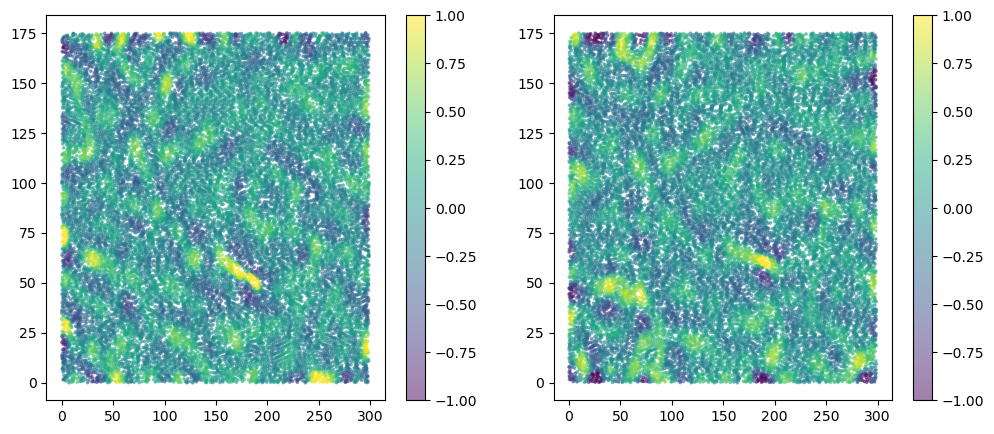

In [7]:
plt.rcParams['figure.figsize'] = [12, 5]
plt.subplot(1,2,1)
plt.scatter(t0_mesh.vertices[:,0],
            t0_mesh.vertices[:,1],
            c=t0_curvature,s=3,alpha=0.5)
plt.clim([-1,1])
plt.colorbar()

plt.subplot(1,2,2)
plt.scatter(t1_mesh.vertices[:,0],
            t1_mesh.vertices[:,1],
            c=t1_curvature,s=3,alpha=0.5)
plt.clim([-1,1])
plt.colorbar()

In [27]:
ZZ,XX,_ = t0.shape
# Match the 'pixel grid' to the 'microns grid' used by Trimesh
pixel_gridX = np.arange(XX)
# gridY,gridX = np.meshgrid()
pixel_gridX_crop = pixel_gridX
pixel_gridY_crop = pixel_gridX

micron_Xmin,micron_Xmax = t0_mesh.vertices[:,0].min(),t0_mesh.vertices[:,1].max()
micron_Ymin,micron_Ymax = t0_mesh.vertices[:,1].min(),t0_mesh.vertices[:,0].max()

Ngrid = 1024; 
Ngrid = Xtrim.stop - Xtrim.start
micron_gridX = np.linspace(0,micron_Xmax,Ngrid)
micron_gridY = np.linspace(0,micron_Ymax,Ngrid)
micron_gridXX,micron_gridYY = np.meshgrid( micron_gridX, micron_gridY)


(1024, 1024)

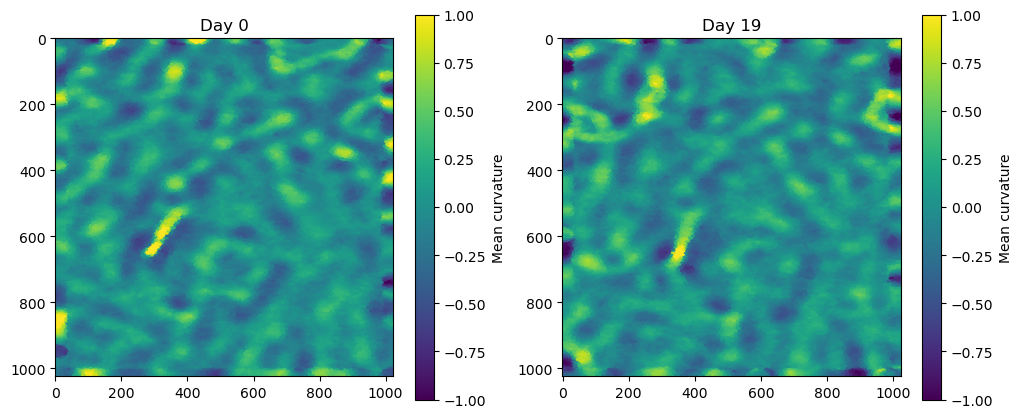

In [33]:

interp = NearestNDInterpolator(list(zip(t0_mesh.vertices[:,1], t0_mesh.vertices[:,0])), t0_curvature)
plt.subplot(1,2,1)
plt.title('Day 0')
t0_curve_grid = interp( micron_gridXX,micron_gridYY )
plt.imshow(t0_curve_grid)
plt.clim([-1,1])
plt.colorbar(label='Mean curvature')

interp = NearestNDInterpolator(list(zip(t1_mesh.vertices[:,1], t1_mesh.vertices[:,0])), t1_curvature)
plt.subplot(1,2,2)
plt.title('Day 19')
t1_curve_grid = interp( micron_gridXX,micron_gridYY )
plt.imshow(t1_curve_grid)
plt.clim([-1,1])

plt.colorbar(label='Mean curvature')
t1_curve_grid.shape

In [8]:
# # Export curvature images

# # Pad out the cropped out region with 0
# t0_reconstructed = np.zeros((XX,XX),dtype=float)
# t1_reconstructed = np.zeros((XX,XX),dtype=float)

# t0_reconstructed[Y_trim,X_trim] = t0_curve_grid
# t1_reconstructed[Y_trim,X_trim] = t1_curve_grid

# io.imsave(path.join(dirname,'0. Day 0/curvature.tif'),util.img_as_int(normalize_image_intensity_signed(t0_reconstructed)))
# io.imsave(path.join(dirname,'1. Day 18/curvature.tif'),util.img_as_int(normalize_image_intensity_signed(t1_reconstructed)))

# np.savez(path.join(dirname,'0. Day 0/curvature.npz'),t0_reconstructed)
# np.savez(path.join(dirname,'1. Day 18/curvature.npz'),t1_reconstructed)

In [18]:
t0_curve_grid.shape

(1024, 1024)

In [58]:
transform.EuclideanTransform(T).translation

array([ 46.83405546, -32.52748086])

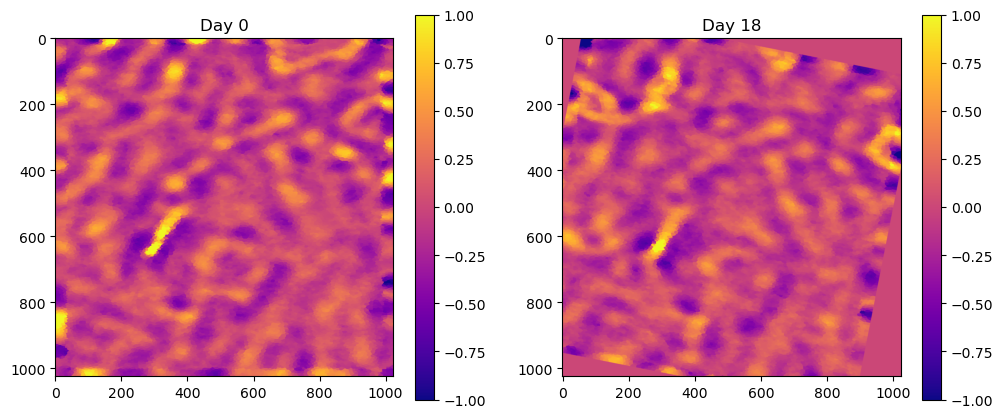

In [50]:
# rotation
from pystackreg import StackReg
from skimage import transform

Xtrim = slice(100,900)
Ytrim = slice(100,900)

sr = StackReg(StackReg.RIGID_BODY)
T = sr.register(t0_curve_grid[Xtrim,Ytrim],t1_curve_grid[Xtrim,Ytrim])
T = transform.EuclideanTransform(T)
# T = T + transform.EuclideanTransform(translation=[0,-5])
# T = T + transform.EuclideanTransform(rotation=np.deg2rad(1))
t1_curve_grid_transform = transform.warp(t1_curve_grid,T)

plt.subplot(1,2,1)
plt.title('Day 0')
plt.imshow(t0_curve_grid,clim=[-1,1],cmap='plasma')
# plt.pcolor(gridX,gridY,t0_curve_grid)
plt.clim([-1,1])
plt.colorbar()

plt.subplot(1,2,2)
plt.title('Day 18')
plt.imshow(t1_curve_grid_transform,clim=[-1,1],cmap='plasma')
# plt.pcolor(gridX,gridY,t1_curve_grid)
plt.clim([-1,1])

plt.colorbar()

plt.savefig(path.join(dirname,'curvature.svg'))

stackview.switch({'t0':t0_curve_grid[Xtrim,Ytrim],
                  't1_raw':t1_curve_grid[Xtrim,Ytrim],
                  't1_reg':t1_curve_grid_transform[Xtrim,Ytrim]},
                 colormap=['pure_green','pure_magenta','pure_red'],
                 toggleable=True,zoom_factor=0.5)

In [69]:
(1197 -1*int(len(C)/4) )/2

399.0

0.49360709093312866


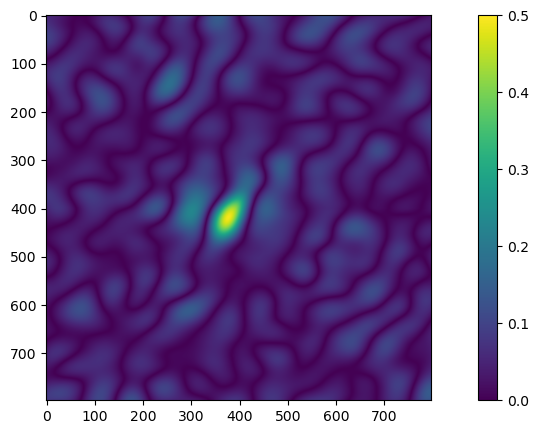

In [54]:
from mathUtils import normxcorr2

C = normxcorr2(t0_curve_grid[Xtrim,Ytrim],t1_curve_grid_transform[Xtrim,Ytrim])
fig = plt.figure()
plt.imshow(C[ 1*int(len(C)/4):3*int(len(C)/4), 1*int(len(C)/4):3*int(len(C)/4) ])
plt.clim([0,.5])

fig.gca().set_aspect('equal', 'box')
plt.colorbar()
fig.savefig(path.join(dirname,'spatial_correlation.svg'))
print(C.max())

# Save

In [52]:
# Plot alongside the raw images
t0_R = io.imread(path.join(dirname,'0. Day 0/G_reg.tif'))
t1_R = io.imread(path.join(dirname,'1. Day 18/G_reg.tif'))

MIP_t0_R = t0_R.max(axis=0)[Y_trim,X_trim]
MIP_t1_R = t1_R.max(axis=0)[Y_trim,X_trim]

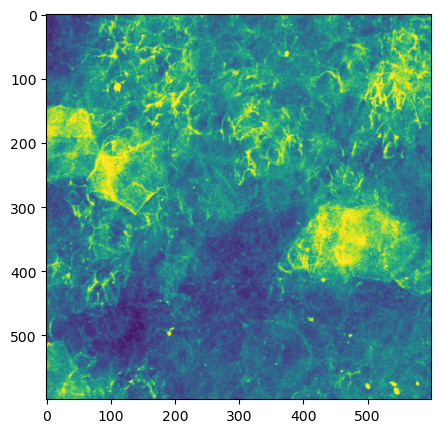

In [53]:
plt.imshow(MIP_t0_R)

In [67]:
t0_curvature

array([-1.67449531, -0.54555334,  0.0944696 , ...,  0.5581811 ,
        0.50719127,  0.5701386 ])

# Use curvature to auto align time points

In [46]:
from trimesh import registration
from scipy.spatial.transform import Rotation

T,_ = registration.mesh_other(t0_mesh,t1_mesh)

pl = pv.Plotter()
pl.add_mesh(t0_mesh,color='red')
pl.add_mesh(t1_mesh)
pl.show()

Widget(value='<iframe src="http://localhost:51892/index.html?ui=P_0x35b834dd0_10&reconnect=auto" class="pyvist…

In [45]:


# transforming mesh1
t1_mesh_transformed = t1_mesh.copy()
t1_mesh_transformed.apply_transform(T)

pl = pv.Plotter()
pl.add_mesh(t0_mesh,color='red')
pl.add_mesh(t1_mesh)
pl.show()

# saving mesh1 as STL file
# mesh1.export('rigidly_aligned_mesh.stl')

Widget(value='<iframe src="http://localhost:51892/index.html?ui=P_0x3a9ea3140_9&reconnect=auto" class="pyvista…

In [47]:
T

array([[ 0.99868526,  0.01642206, -0.0485599 ,  3.4688129 ],
       [-0.01477884,  0.99931233,  0.03400659,  4.04918631],
       [ 0.04908496, -0.03324422,  0.9982412 , 11.27674525],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [33]:
from scipy import ndimage

t1_crop_transformed = ndimage.affine_transform(t1_crop,T)

stackview.slice(t1_crop)

In [5]:
import trimesh
mesh = trimesh.load_mesh('/Users/xies/Downloads/Stanford_Bunny.stl')

pl = pv.Plotter()
pl.add_mesh(pv.wrap(mesh))
pl.show()

Widget(value='<iframe src="http://localhost:56926/index.html?ui=P_0x32179a750_0&reconnect=auto" class="pyvista…

In [6]:
curv = get_tissue_curvatures(mesh)

In [9]:
curv[0].shape

(56203,)